## Чтение и очистка трейна

In [1]:
import numpy as np
import pandas as pd
import html
import string

In [3]:
data = pd.read_json('ranking_train.jsonl', lines=True)
new_rows = []
for index, row in data.iterrows():
    for comment in row['comments']:
        new_row = {'text': row['text'], 'comments_text': comment['text'], 'comments_score': comment['score']}
        new_rows.append(new_row)

In [4]:
data = pd.DataFrame(new_rows)
data = data.reset_index(drop=True)
data

,text,comments_text,comments_score
0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0
1,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1
2,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2
3,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3
4,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4
...,...,...,...
440530,Pay your rent with a Credit or Debit card. No ...,Most major banks offer a service called &#x27;...,0
440531,Pay your rent with a Credit or Debit card. No ...,"It costs 3.25%, or $74.25 for the example of $...",1
440532,Pay your rent with a Credit or Debit card. No ...,As many other comments have pointed out almost...,2
440533,Pay your rent with a Credit or Debit card. No ...,My apartment building uses Yapstone&#x27;s Ren...,3


In [66]:
def preprocessing(data):

    for column in data.columns:
        #заменяем коды на символы
        data[column] = data[column].apply(html.unescape)

        #заменяем url'ы на токен 1url1
        data[column] = data[column].str.replace(
        r"(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])",
        '1url1',
        regex=True)

        #заменяем email'ы на токен 1email1
        data[column] = data[column].str.replace(
            r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])",
            '1email1',
            regex=True)

        #убираем ссылки
        data[column] = data[column].str.replace(r'\[\d\]', '', regex=True)

        # #понижаем регистр
        data[column] = data[column].apply(lambda x: x.lower())

        #избавляемся от лишних знаков пунктуации
        data[column] = data[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation + "\n")))

        #делаем обратную замену на <token>
        data[column] = data[column].str.replace('1url1', ' <url> ')
        data[column] = data[column].str.replace('1email1', ' <email> ')

    return data

In [6]:
data.iloc[:, :2] = preprocessing(data.iloc[:, :2])
data

,text,comments_text,comments_score
0,how many summer y combinator fundees decided n...,going back to school is not identical with giv...,0
1,how many summer y combinator fundees decided n...,there will invariably be those who dont see th...,1
2,how many summer y combinator fundees decided n...,for me school is a way to be connected to what...,2
3,how many summer y combinator fundees decided n...,i guess it really depends on how hungry you ar...,3
4,how many summer y combinator fundees decided n...,i know pollground decided to go back to school...,4
...,...,...,...
440530,pay your rent with a credit or debit card no l...,most major banks offer a service called bill p...,0
440531,pay your rent with a credit or debit card no l...,it costs 325 or 7425 for the example of 2300 s...,1
440532,pay your rent with a credit or debit card no l...,as many other comments have pointed out almost...,2
440533,pay your rent with a credit or debit card no l...,my apartment building uses yapstones rentpayme...,3


# Train-Val Split

In [7]:
from sklearn.model_selection import GroupShuffleSplit

# подготавливаем train и val данные для итоговой валидации
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=42)
split = splitter.split(data, groups=data['text'])
train_inds, val_inds = next(split)

main_train = data.iloc[train_inds]
main_val = data.iloc[val_inds]

In [8]:
# подготавливаем train и test данные для сравнения эмбеддингов
split = splitter.split(main_train, groups=main_train['text'])
train_inds, test_inds = next(split)

train = main_train.iloc[train_inds]
test = main_train.iloc[test_inds]

# Векторизация

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

import gensim.downloader
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [140]:
import vector_space_models_utils
from vector_space_models_utils import hits_score
from vector_space_models_utils import dcg_score

In [12]:
stopWords = set(stopwords.words('english'))

In [13]:
class NLTK_Tokenizer:
    def __init__(self, delete_punctuation=False, delete_stop_words=False):
        self.delete_punctuation = delete_punctuation
        self.delete_stop_words = delete_stop_words
    def tokenize(self, text, ):
        if self.delete_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text.lower())
        if self.delete_stop_words:
            return [token for token in tokens if token not in stopWords]
        return tokens

nltk_tokenizer = NLTK_Tokenizer()

In [14]:
embeddings_list = [('glove-wiki-gigaword-50', 50),
                   ('glove-wiki-gigaword-100', 100),
                   ('glove-wiki-gigaword-200', 200),
                   ('glove-twitter-25', 25),
                   ('glove-twitter-50', 50),
                   ('glove-twitter-100', 100)]

In [15]:
def text_to_vec(text, embeddings, tokenizer, dim=200, aggregation='mean', verbose=False):
    """
        text: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении

        return: векторное представление для вопроса
    """
    tokens = tokenizer.tokenize(text)

    result = np.zeros(dim)

    if verbose:
        print('Initial text:', text)
        print('Tokens:', tokens)

    if aggregation == 'mean':
        iterator = 0

        for word in tokens:
            if word in embeddings:
                result += embeddings[word]
                iterator += 1
                if verbose and dim > 5:
                    print('Word and its embedding:', word, embeddings[word][:5])

        if iterator != 0:
            result = result / iterator
    else:
        raise AttributeError(f'No aggregation type {aggregation}, please, use other')


    return result

In [16]:
def transform_data(data, current_embeddings, current_tokenizer, vector_dim):

    X_text_raw = data['text']
    X_comm_raw = data['comments_text']
    y = np.array(data['comments_score'])

    text_emb = [text_to_vec(row, current_embeddings, current_tokenizer, vector_dim) for row in X_text_raw]
    comm_emb = [text_to_vec(row, current_embeddings, current_tokenizer, vector_dim) for row in X_comm_raw]
    embeddings = [np.concatenate((text, comm)) for text, comm in zip(text_emb, comm_emb)]

    idx = []
    for i in range(int(len(embeddings) / 5)):
        idx.extend([i] * 5)

    embeddings_df = pd.DataFrame(embeddings, columns=[i for i in range(1, 2*vector_dim+1)])
    embeddings_df['score'] = y
    embeddings_df['qid'] = idx

    qids = embeddings_df.groupby('qid')['qid'].count().to_numpy()
    X = embeddings_df.drop(['score'], axis = 1)

    return X, y, qids

# Сравнение различных эмбеддингов для LambdaMART модели

In [28]:
import lightgbm

In [29]:
scores = dict()

for embedding_name, vector_dim in tqdm(embeddings_list):

    print()

    current_embeddings = gensim.downloader.load(embedding_name)
    current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)

    print()
    print(embedding_name)
    print()

    # Подготавливаем данные для подачи в модель
    X_train, y_train, qids_train = transform_data(train, current_embeddings, current_tokenizer, vector_dim)
    X_test, y_test, qids_test = transform_data(test, current_embeddings, current_tokenizer, vector_dim)

    X_train = X_train.drop(['qid'], axis=1)
    X_test = X_test.drop(['qid'], axis=1)

    # Создаем модель
    ranker = lightgbm.LGBMRanker(
        objective='lambdarank',
        boosting_type='gbdt',
        n_estimators=5,
        importance_type='gain',
        metric='ndcg',
        num_leaves=10,
        learning_rate=0.05,
        max_depth=-1,
        label_gain=[i for i in range(5)]
    )

    # Обучаем модель
    ranker.fit(
        X=X_train,
        y=y_train,
        group=qids_train,
        eval_set=[(X_test, y_test)],
        eval_group=[qids_test],
        eval_at=[1, 3, 5]
    )

    # Сохраняем результат
    scores[embedding_name] = [ranker.best_score_['valid_0']['ndcg@1'],
                              ranker.best_score_['valid_0']['ndcg@3'],
                              ranker.best_score_['valid_0']['ndcg@5']]

  0%|          | 0/6 [00:00<?, ?it/s]



glove-wiki-gigaword-50

[1]	valid_0's ndcg@1: 0.494754	valid_0's ndcg@3: 0.576375	valid_0's ndcg@5: 0.792423
[2]	valid_0's ndcg@1: 0.592596	valid_0's ndcg@3: 0.657437	valid_0's ndcg@5: 0.831721
[3]	valid_0's ndcg@1: 0.615085	valid_0's ndcg@3: 0.687357	valid_0's ndcg@5: 0.84403
[4]	valid_0's ndcg@1: 0.628341	valid_0's ndcg@3: 0.701477	valid_0's ndcg@5: 0.850235
[5]	valid_0's ndcg@1: 0.632487	valid_0's ndcg@3: 0.70941	valid_0's ndcg@5: 0.853273


 17%|█▋        | 1/6 [05:29<27:25, 329.03s/it]



glove-wiki-gigaword-100

[1]	valid_0's ndcg@1: 0.502322	valid_0's ndcg@3: 0.58939	valid_0's ndcg@5: 0.796973
[2]	valid_0's ndcg@1: 0.598391	valid_0's ndcg@3: 0.672096	valid_0's ndcg@5: 0.836633
[3]	valid_0's ndcg@1: 0.622935	valid_0's ndcg@3: 0.697943	valid_0's ndcg@5: 0.848421
[4]	valid_0's ndcg@1: 0.630095	valid_0's ndcg@3: 0.704986	valid_0's ndcg@5: 0.851702


 33%|███▎      | 2/6 [12:04<24:33, 368.28s/it]

[5]	valid_0's ndcg@1: 0.637804	valid_0's ndcg@3: 0.713174	valid_0's ndcg@5: 0.855366


glove-wiki-gigaword-200

[1]	valid_0's ndcg@1: 0.48678	valid_0's ndcg@3: 0.592667	valid_0's ndcg@5: 0.795665
[2]	valid_0's ndcg@1: 0.59715	valid_0's ndcg@3: 0.679566	valid_0's ndcg@5: 0.838768
[3]	valid_0's ndcg@1: 0.625115	valid_0's ndcg@3: 0.703478	valid_0's ndcg@5: 0.850508
[4]	valid_0's ndcg@1: 0.634915	valid_0's ndcg@3: 0.713802	valid_0's ndcg@5: 0.855167


 50%|█████     | 3/6 [20:43<21:51, 437.03s/it]

[5]	valid_0's ndcg@1: 0.640746	valid_0's ndcg@3: 0.721079	valid_0's ndcg@5: 0.858539


glove-twitter-25

[1]	valid_0's ndcg@1: 0.497058	valid_0's ndcg@3: 0.593753	valid_0's ndcg@5: 0.797305
[2]	valid_0's ndcg@1: 0.590469	valid_0's ndcg@3: 0.65394	valid_0's ndcg@5: 0.830205
[3]	valid_0's ndcg@1: 0.60789	valid_0's ndcg@3: 0.678969	valid_0's ndcg@5: 0.840199
[4]	valid_0's ndcg@1: 0.61489	valid_0's ndcg@3: 0.688957	valid_0's ndcg@5: 0.844425


 67%|██████▋   | 4/6 [26:05<13:02, 391.41s/it]

[5]	valid_0's ndcg@1: 0.623237	valid_0's ndcg@3: 0.700228	valid_0's ndcg@5: 0.849124

[==================================================] 100.0% 199.5/199.5MB downloaded

glove-twitter-50

[1]	valid_0's ndcg@1: 0.496367	valid_0's ndcg@3: 0.605101	valid_0's ndcg@5: 0.80062
[2]	valid_0's ndcg@1: 0.597523	valid_0's ndcg@3: 0.67527	valid_0's ndcg@5: 0.837653
[3]	valid_0's ndcg@1: 0.619994	valid_0's ndcg@3: 0.6927	valid_0's ndcg@5: 0.846487
[4]	valid_0's ndcg@1: 0.632452	valid_0's ndcg@3: 0.703607	valid_0's ndcg@5: 0.851436


 83%|████████▎ | 5/6 [33:09<06:43, 403.29s/it]

[5]	valid_0's ndcg@1: 0.636865	valid_0's ndcg@3: 0.71036	valid_0's ndcg@5: 0.854143

[==================================================] 100.0% 387.1/387.1MB downloaded

glove-twitter-100

[1]	valid_0's ndcg@1: 0.487613	valid_0's ndcg@3: 0.610096	valid_0's ndcg@5: 0.800731
[2]	valid_0's ndcg@1: 0.597966	valid_0's ndcg@3: 0.677797	valid_0's ndcg@5: 0.838546
[3]	valid_0's ndcg@1: 0.627224	valid_0's ndcg@3: 0.702181	valid_0's ndcg@5: 0.850405
[4]	valid_0's ndcg@1: 0.636103	valid_0's ndcg@3: 0.712656	valid_0's ndcg@5: 0.854873


100%|██████████| 6/6 [42:48<00:00, 428.01s/it]

[5]	valid_0's ndcg@1: 0.642075	valid_0's ndcg@3: 0.720529	valid_0's ndcg@5: 0.858173


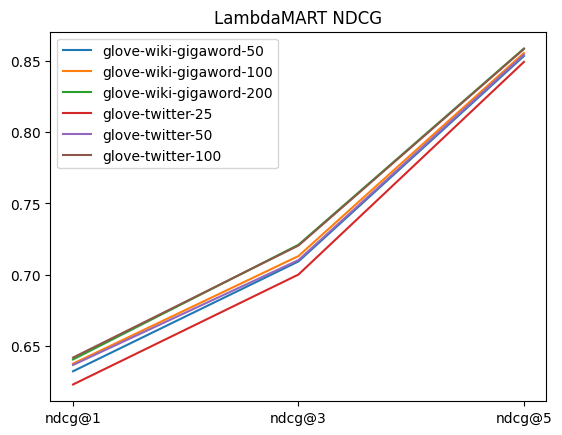

In [46]:
import matplotlib.pyplot as plt

x_values = list(range(len(scores[list(scores.keys())[0]])))
x_ticks = ['ndcg@1', 'ndcg@3', 'ndcg@5']

for key, values in scores.items():
    plt.plot(x_values, values, label=key)
plt.xticks(x_values, x_ticks)
plt.title('LambdaMART NDCG')
plt.legend()
plt.show()

Наилучшими моделями по метрике качества оказались glove-wiki-gigaword-200 и glove-twitter-100. Чтобы сократить размер используемых эмбеддингов, в дальнейшем будем использовать glove-twitter-100.

# Оптимизация гиперпараметров

In [44]:
import optuna

In [47]:
# Возьмем за основу оптимальный вариант (glove-twitter-100)
embedding_name = embeddings_list[5][0]
vector_dim = embeddings_list[5][1]

current_embeddings = gensim.downloader.load(embedding_name)
current_tokenizer = NLTK_Tokenizer(delete_punctuation=True, delete_stop_words=True)

X, y, _ = transform_data(main_train, current_embeddings, current_tokenizer, vector_dim)

In [48]:
def objective(trial, X, y):
    params = {
        'objective': 'lambdarank',
        'boosting_type': 'gbdt',
        'n_estimators': 5,
        'importance_type': 'gain',
        'metric': 'ndcg',
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'label_gain': [i for i in range(5)]
    }

    cv = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=42)

    scores = []

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=X['qid'])):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        ranker = lightgbm.LGBMRanker(**params)

        qids_train = X_train.groupby('qid')['qid'].count().to_numpy()
        qids_test = X_test.groupby('qid')['qid'].count().to_numpy()

        X_train = X_train.drop(['qid'], axis=1)
        X_test = X_test.drop(['qid'], axis=1)

        ranker.fit(
            X=X_train,
            y=y_train,
            group=qids_train,
            eval_set=[(X_test, y_test)],
            eval_group=[qids_test],
            eval_at=[1, 3, 5]
        )

        ndcg = ranker.best_score_['valid_0']['ndcg@5']
        scores.append(ndcg)

    return np.mean(scores)

study = optuna.create_study(direction='maximize', study_name='LGBMRanker')
func = lambda trial: objective(trial, X=X, y=y)
study.optimize(func, n_trials=50)

print('Best trial:')
best_trial = study.best_trial
print('NDCG: {}'.format(best_trial.value))
print('Hyperparameters: {}'.format(best_trial.params))

[I 2023-06-25 17:24:50,762] A new study created in memory with name: LGBMRanker


[1]	valid_0's ndcg@1: 0.575743	valid_0's ndcg@3: 0.632271	valid_0's ndcg@5: 0.821164
[2]	valid_0's ndcg@1: 0.616585	valid_0's ndcg@3: 0.677058	valid_0's ndcg@5: 0.841023
[3]	valid_0's ndcg@1: 0.634621	valid_0's ndcg@3: 0.703487	valid_0's ndcg@5: 0.85181
[4]	valid_0's ndcg@1: 0.642885	valid_0's ndcg@3: 0.715278	valid_0's ndcg@5: 0.856636
[5]	valid_0's ndcg@1: 0.649163	valid_0's ndcg@3: 0.722194	valid_0's ndcg@5: 0.859744
[1]	valid_0's ndcg@1: 0.567816	valid_0's ndcg@3: 0.617989	valid_0's ndcg@5: 0.81605
[2]	valid_0's ndcg@1: 0.619387	valid_0's ndcg@3: 0.681468	valid_0's ndcg@5: 0.842907
[3]	valid_0's ndcg@1: 0.636394	valid_0's ndcg@3: 0.704204	valid_0's ndcg@5: 0.852379
[4]	valid_0's ndcg@1: 0.642264	valid_0's ndcg@3: 0.715047	valid_0's ndcg@5: 0.856618


[I 2023-06-25 17:25:26,033] Trial 0 finished with value: 0.8594528732643594 and parameters: {'num_leaves': 42, 'learning_rate': 0.07943563076086084, 'max_depth': 7}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.645581	valid_0's ndcg@3: 0.721242	valid_0's ndcg@5: 0.859162
[1]	valid_0's ndcg@1: 0.406948	valid_0's ndcg@3: 0.487549	valid_0's ndcg@5: 0.751683
[2]	valid_0's ndcg@1: 0.523906	valid_0's ndcg@3: 0.572161	valid_0's ndcg@5: 0.795465
[3]	valid_0's ndcg@1: 0.573083	valid_0's ndcg@3: 0.623845	valid_0's ndcg@5: 0.81841
[4]	valid_0's ndcg@1: 0.589948	valid_0's ndcg@3: 0.639585	valid_0's ndcg@5: 0.825932
[5]	valid_0's ndcg@1: 0.600074	valid_0's ndcg@3: 0.65142	valid_0's ndcg@5: 0.830996
[1]	valid_0's ndcg@1: 0.403969	valid_0's ndcg@3: 0.485781	valid_0's ndcg@5: 0.75082
[2]	valid_0's ndcg@1: 0.516298	valid_0's ndcg@3: 0.57119	valid_0's ndcg@5: 0.793902
[3]	valid_0's ndcg@1: 0.566947	valid_0's ndcg@3: 0.623702	valid_0's ndcg@5: 0.817449
[4]	valid_0's ndcg@1: 0.590055	valid_0's ndcg@3: 0.646224	valid_0's ndcg@5: 0.827569


[I 2023-06-25 17:25:56,508] Trial 1 finished with value: 0.8311595731078227 and parameters: {'num_leaves': 4, 'learning_rate': 0.037973867519668116, 'max_depth': -1}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.598833	valid_0's ndcg@3: 0.653744	valid_0's ndcg@5: 0.831323
[1]	valid_0's ndcg@1: 0.454334	valid_0's ndcg@3: 0.501769	valid_0's ndcg@5: 0.763367
[2]	valid_0's ndcg@1: 0.533748	valid_0's ndcg@3: 0.571132	valid_0's ndcg@5: 0.796655
[3]	valid_0's ndcg@1: 0.578403	valid_0's ndcg@3: 0.619414	valid_0's ndcg@5: 0.817995
[4]	valid_0's ndcg@1: 0.597521	valid_0's ndcg@3: 0.646399	valid_0's ndcg@5: 0.829155
[5]	valid_0's ndcg@1: 0.612293	valid_0's ndcg@3: 0.668362	valid_0's ndcg@5: 0.838063
[1]	valid_0's ndcg@1: 0.449723	valid_0's ndcg@3: 0.499992	valid_0's ndcg@5: 0.762222
[2]	valid_0's ndcg@1: 0.54125	valid_0's ndcg@3: 0.57661	valid_0's ndcg@5: 0.799466
[3]	valid_0's ndcg@1: 0.584256	valid_0's ndcg@3: 0.628401	valid_0's ndcg@5: 0.821604
[4]	valid_0's ndcg@1: 0.603497	valid_0's ndcg@3: 0.650708	valid_0's ndcg@5: 0.831268


[I 2023-06-25 17:26:27,212] Trial 2 finished with value: 0.8372262391512283 and parameters: {'num_leaves': 46, 'learning_rate': 0.04366256072523495, 'max_depth': 3}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.614439	valid_0's ndcg@3: 0.662043	valid_0's ndcg@5: 0.836389
[1]	valid_0's ndcg@1: 0.505409	valid_0's ndcg@3: 0.543129	valid_0's ndcg@5: 0.783939
[2]	valid_0's ndcg@1: 0.567408	valid_0's ndcg@3: 0.605339	valid_0's ndcg@5: 0.812185
[3]	valid_0's ndcg@1: 0.600252	valid_0's ndcg@3: 0.647198	valid_0's ndcg@5: 0.829946
[4]	valid_0's ndcg@1: 0.615681	valid_0's ndcg@3: 0.667523	valid_0's ndcg@5: 0.838234
[5]	valid_0's ndcg@1: 0.627509	valid_0's ndcg@3: 0.685888	valid_0's ndcg@5: 0.845586
[1]	valid_0's ndcg@1: 0.50133	valid_0's ndcg@3: 0.541848	valid_0's ndcg@5: 0.782808
[2]	valid_0's ndcg@1: 0.575176	valid_0's ndcg@3: 0.613134	valid_0's ndcg@5: 0.815647
[3]	valid_0's ndcg@1: 0.601227	valid_0's ndcg@3: 0.646977	valid_0's ndcg@5: 0.829843
[4]	valid_0's ndcg@1: 0.61529	valid_0's ndcg@3: 0.662932	valid_0's ndcg@5: 0.836768


[I 2023-06-25 17:26:58,612] Trial 3 finished with value: 0.8451122320749807 and parameters: {'num_leaves': 37, 'learning_rate': 0.0316491640815509, 'max_depth': 4}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.625222	valid_0's ndcg@3: 0.684143	valid_0's ndcg@5: 0.844639
[1]	valid_0's ndcg@1: 0.557335	valid_0's ndcg@3: 0.635525	valid_0's ndcg@5: 0.819142
[2]	valid_0's ndcg@1: 0.608924	valid_0's ndcg@3: 0.684746	valid_0's ndcg@5: 0.842127
[3]	valid_0's ndcg@1: 0.612329	valid_0's ndcg@3: 0.688883	valid_0's ndcg@5: 0.843925
[4]	valid_0's ndcg@1: 0.623235	valid_0's ndcg@3: 0.699403	valid_0's ndcg@5: 0.848835
[5]	valid_0's ndcg@1: 0.624725	valid_0's ndcg@3: 0.70143	valid_0's ndcg@5: 0.84962
[1]	valid_0's ndcg@1: 0.554143	valid_0's ndcg@3: 0.621055	valid_0's ndcg@5: 0.814642
[2]	valid_0's ndcg@1: 0.600642	valid_0's ndcg@3: 0.672061	valid_0's ndcg@5: 0.837058
[3]	valid_0's ndcg@1: 0.612293	valid_0's ndcg@3: 0.682699	valid_0's ndcg@5: 0.842034
[4]	valid_0's ndcg@1: 0.618429	valid_0's ndcg@3: 0.692168	valid_0's ndcg@5: 0.845944


[I 2023-06-25 17:27:32,386] Trial 4 finished with value: 0.8494536854071624 and parameters: {'num_leaves': 19, 'learning_rate': 0.013262301884082164, 'max_depth': 8}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.625647	valid_0's ndcg@3: 0.699831	valid_0's ndcg@5: 0.849287
[1]	valid_0's ndcg@1: 0.534387	valid_0's ndcg@3: 0.576087	valid_0's ndcg@5: 0.798284
[2]	valid_0's ndcg@1: 0.591367	valid_0's ndcg@3: 0.642394	valid_0's ndcg@5: 0.826754
[3]	valid_0's ndcg@1: 0.615149	valid_0's ndcg@3: 0.67461	valid_0's ndcg@5: 0.840203
[4]	valid_0's ndcg@1: 0.628928	valid_0's ndcg@3: 0.693891	valid_0's ndcg@5: 0.848128
[5]	valid_0's ndcg@1: 0.63815	valid_0's ndcg@3: 0.704021	valid_0's ndcg@5: 0.852565
[1]	valid_0's ndcg@1: 0.533323	valid_0's ndcg@3: 0.572476	valid_0's ndcg@5: 0.796986
[2]	valid_0's ndcg@1: 0.599844	valid_0's ndcg@3: 0.641574	valid_0's ndcg@5: 0.828078
[3]	valid_0's ndcg@1: 0.623785	valid_0's ndcg@3: 0.674857	valid_0's ndcg@5: 0.841713
[4]	valid_0's ndcg@1: 0.634514	valid_0's ndcg@3: 0.695244	valid_0's ndcg@5: 0.849666


[I 2023-06-25 17:28:03,619] Trial 5 finished with value: 0.8539030177165285 and parameters: {'num_leaves': 41, 'learning_rate': 0.0767155358238994, 'max_depth': 5}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.644375	valid_0's ndcg@3: 0.710041	valid_0's ndcg@5: 0.855241
[1]	valid_0's ndcg@1: 0.560988	valid_0's ndcg@3: 0.627097	valid_0's ndcg@5: 0.817338
[2]	valid_0's ndcg@1: 0.605377	valid_0's ndcg@3: 0.668611	valid_0's ndcg@5: 0.836774
[3]	valid_0's ndcg@1: 0.622012	valid_0's ndcg@3: 0.693409	valid_0's ndcg@5: 0.846772
[4]	valid_0's ndcg@1: 0.630045	valid_0's ndcg@3: 0.70566	valid_0's ndcg@5: 0.851707
[5]	valid_0's ndcg@1: 0.63251	valid_0's ndcg@3: 0.708999	valid_0's ndcg@5: 0.85309
[1]	valid_0's ndcg@1: 0.554959	valid_0's ndcg@3: 0.613508	valid_0's ndcg@5: 0.812599
[2]	valid_0's ndcg@1: 0.612471	valid_0's ndcg@3: 0.670072	valid_0's ndcg@5: 0.838444
[3]	valid_0's ndcg@1: 0.629371	valid_0's ndcg@3: 0.693606	valid_0's ndcg@5: 0.848169
[4]	valid_0's ndcg@1: 0.635774	valid_0's ndcg@3: 0.70609	valid_0's ndcg@5: 0.852786


[I 2023-06-25 17:28:34,876] Trial 6 finished with value: 0.8539922687127308 and parameters: {'num_leaves': 23, 'learning_rate': 0.024438685459267064, 'max_depth': 7}. Best is trial 0 with value: 0.8594528732643594.


[5]	valid_0's ndcg@1: 0.639019	valid_0's ndcg@3: 0.71091	valid_0's ndcg@5: 0.854894
[1]	valid_0's ndcg@1: 0.578385	valid_0's ndcg@3: 0.67697	valid_0's ndcg@5: 0.835106
[2]	valid_0's ndcg@1: 0.613694	valid_0's ndcg@3: 0.707132	valid_0's ndcg@5: 0.849938
[3]	valid_0's ndcg@1: 0.623271	valid_0's ndcg@3: 0.713497	valid_0's ndcg@5: 0.853459
[4]	valid_0's ndcg@1: 0.629265	valid_0's ndcg@3: 0.718371	valid_0's ndcg@5: 0.855998
[5]	valid_0's ndcg@1: 0.636784	valid_0's ndcg@3: 0.723606	valid_0's ndcg@5: 0.858626
[1]	valid_0's ndcg@1: 0.584078	valid_0's ndcg@3: 0.680569	valid_0's ndcg@5: 0.837161
[2]	valid_0's ndcg@1: 0.62015	valid_0's ndcg@3: 0.711202	valid_0's ndcg@5: 0.852195
[3]	valid_0's ndcg@1: 0.636979	valid_0's ndcg@3: 0.720443	valid_0's ndcg@5: 0.857818
[4]	valid_0's ndcg@1: 0.643949	valid_0's ndcg@3: 0.726462	valid_0's ndcg@5: 0.860638


[I 2023-06-25 17:29:07,672] Trial 7 finished with value: 0.8602425514530663 and parameters: {'num_leaves': 45, 'learning_rate': 0.02147740963433883, 'max_depth': -1}. Best is trial 7 with value: 0.8602425514530663.


[5]	valid_0's ndcg@1: 0.646964	valid_0's ndcg@3: 0.728562	valid_0's ndcg@5: 0.861859
[1]	valid_0's ndcg@1: 0.448411	valid_0's ndcg@3: 0.500197	valid_0's ndcg@5: 0.761997
[2]	valid_0's ndcg@1: 0.511687	valid_0's ndcg@3: 0.54402	valid_0's ndcg@5: 0.785155
[3]	valid_0's ndcg@1: 0.553735	valid_0's ndcg@3: 0.587316	valid_0's ndcg@5: 0.804849
[4]	valid_0's ndcg@1: 0.565386	valid_0's ndcg@3: 0.59824	valid_0's ndcg@5: 0.809993
[5]	valid_0's ndcg@1: 0.579254	valid_0's ndcg@3: 0.619987	valid_0's ndcg@5: 0.818584
[1]	valid_0's ndcg@1: 0.44552	valid_0's ndcg@3: 0.498738	valid_0's ndcg@5: 0.761191
[2]	valid_0's ndcg@1: 0.534032	valid_0's ndcg@3: 0.571395	valid_0's ndcg@5: 0.797033
[3]	valid_0's ndcg@1: 0.56943	valid_0's ndcg@3: 0.609348	valid_0's ndcg@5: 0.813861
[4]	valid_0's ndcg@1: 0.57365	valid_0's ndcg@3: 0.611659	valid_0's ndcg@5: 0.815269


[I 2023-06-25 17:29:38,058] Trial 8 finished with value: 0.8169209302830034 and parameters: {'num_leaves': 6, 'learning_rate': 0.013278311813162847, 'max_depth': 3}. Best is trial 7 with value: 0.8602425514530663.


[5]	valid_0's ndcg@1: 0.572285	valid_0's ndcg@3: 0.612333	valid_0's ndcg@5: 0.815258
[1]	valid_0's ndcg@1: 0.505409	valid_0's ndcg@3: 0.543129	valid_0's ndcg@5: 0.783939
[2]	valid_0's ndcg@1: 0.567106	valid_0's ndcg@3: 0.605289	valid_0's ndcg@5: 0.812131
[3]	valid_0's ndcg@1: 0.597964	valid_0's ndcg@3: 0.640512	valid_0's ndcg@5: 0.827463
[4]	valid_0's ndcg@1: 0.616301	valid_0's ndcg@3: 0.667392	valid_0's ndcg@5: 0.838016
[5]	valid_0's ndcg@1: 0.628272	valid_0's ndcg@3: 0.687683	valid_0's ndcg@5: 0.846
[1]	valid_0's ndcg@1: 0.50133	valid_0's ndcg@3: 0.541848	valid_0's ndcg@5: 0.782808
[2]	valid_0's ndcg@1: 0.573668	valid_0's ndcg@3: 0.610104	valid_0's ndcg@5: 0.814487
[3]	valid_0's ndcg@1: 0.600979	valid_0's ndcg@3: 0.645425	valid_0's ndcg@5: 0.829442
[4]	valid_0's ndcg@1: 0.616319	valid_0's ndcg@3: 0.662113	valid_0's ndcg@5: 0.836777


[I 2023-06-25 17:30:09,794] Trial 9 finished with value: 0.8431914178837996 and parameters: {'num_leaves': 47, 'learning_rate': 0.02667474180350113, 'max_depth': 4}. Best is trial 7 with value: 0.8602425514530663.


[5]	valid_0's ndcg@1: 0.620806	valid_0's ndcg@3: 0.671969	valid_0's ndcg@5: 0.840382
[1]	valid_0's ndcg@1: 0.572267	valid_0's ndcg@3: 0.668515	valid_0's ndcg@5: 0.831384
[2]	valid_0's ndcg@1: 0.599879	valid_0's ndcg@3: 0.695687	valid_0's ndcg@5: 0.844052
[3]	valid_0's ndcg@1: 0.607523	valid_0's ndcg@3: 0.701758	valid_0's ndcg@5: 0.847142
[4]	valid_0's ndcg@1: 0.611229	valid_0's ndcg@3: 0.702384	valid_0's ndcg@5: 0.848015
[5]	valid_0's ndcg@1: 0.614546	valid_0's ndcg@3: 0.70579	valid_0's ndcg@5: 0.849499
[1]	valid_0's ndcg@1: 0.573083	valid_0's ndcg@3: 0.670912	valid_0's ndcg@5: 0.832363
[2]	valid_0's ndcg@1: 0.59745	valid_0's ndcg@3: 0.691697	valid_0's ndcg@5: 0.842648
[3]	valid_0's ndcg@1: 0.611247	valid_0's ndcg@3: 0.700097	valid_0's ndcg@5: 0.847318
[4]	valid_0's ndcg@1: 0.622845	valid_0's ndcg@3: 0.711529	valid_0's ndcg@5: 0.852419


[I 2023-06-25 17:30:42,900] Trial 10 finished with value: 0.851042738679063 and parameters: {'num_leaves': 32, 'learning_rate': 0.01033778195771495, 'max_depth': -1}. Best is trial 7 with value: 0.8602425514530663.


[5]	valid_0's ndcg@1: 0.623147	valid_0's ndcg@3: 0.711906	valid_0's ndcg@5: 0.852586
[1]	valid_0's ndcg@1: 0.574041	valid_0's ndcg@3: 0.654651	valid_0's ndcg@5: 0.827548
[2]	valid_0's ndcg@1: 0.619955	valid_0's ndcg@3: 0.699434	valid_0's ndcg@5: 0.848258
[3]	valid_0's ndcg@1: 0.634319	valid_0's ndcg@3: 0.713696	valid_0's ndcg@5: 0.855093
[4]	valid_0's ndcg@1: 0.643453	valid_0's ndcg@3: 0.723043	valid_0's ndcg@5: 0.859154
[5]	valid_0's ndcg@1: 0.646024	valid_0's ndcg@3: 0.726357	valid_0's ndcg@5: 0.86076
[1]	valid_0's ndcg@1: 0.577712	valid_0's ndcg@3: 0.6505	valid_0's ndcg@5: 0.827031
[2]	valid_0's ndcg@1: 0.629567	valid_0's ndcg@3: 0.701663	valid_0's ndcg@5: 0.850602
[3]	valid_0's ndcg@1: 0.64308	valid_0's ndcg@3: 0.717497	valid_0's ndcg@5: 0.857576
[4]	valid_0's ndcg@1: 0.649606	valid_0's ndcg@3: 0.725955	valid_0's ndcg@5: 0.861219


[I 2023-06-25 17:31:14,616] Trial 11 finished with value: 0.8622600261616746 and parameters: {'num_leaves': 32, 'learning_rate': 0.09283697190488013, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.655441	valid_0's ndcg@3: 0.732489	valid_0's ndcg@5: 0.86376
[1]	valid_0's ndcg@1: 0.573065	valid_0's ndcg@3: 0.654321	valid_0's ndcg@5: 0.827257
[2]	valid_0's ndcg@1: 0.62093	valid_0's ndcg@3: 0.697638	valid_0's ndcg@5: 0.847813
[3]	valid_0's ndcg@1: 0.634727	valid_0's ndcg@3: 0.71346	valid_0's ndcg@5: 0.854878
[4]	valid_0's ndcg@1: 0.644215	valid_0's ndcg@3: 0.722381	valid_0's ndcg@5: 0.858993
[5]	valid_0's ndcg@1: 0.650333	valid_0's ndcg@3: 0.727453	valid_0's ndcg@5: 0.861626
[1]	valid_0's ndcg@1: 0.576807	valid_0's ndcg@3: 0.649911	valid_0's ndcg@5: 0.826706
[2]	valid_0's ndcg@1: 0.628875	valid_0's ndcg@3: 0.701775	valid_0's ndcg@5: 0.850426
[3]	valid_0's ndcg@1: 0.640934	valid_0's ndcg@3: 0.716519	valid_0's ndcg@5: 0.857081
[4]	valid_0's ndcg@1: 0.647797	valid_0's ndcg@3: 0.72556	valid_0's ndcg@5: 0.860785


[I 2023-06-25 17:31:48,500] Trial 12 finished with value: 0.8622288033140986 and parameters: {'num_leaves': 31, 'learning_rate': 0.08759095625723963, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.652426	valid_0's ndcg@3: 0.730221	valid_0's ndcg@5: 0.862832
[1]	valid_0's ndcg@1: 0.571505	valid_0's ndcg@3: 0.653384	valid_0's ndcg@5: 0.826745
[2]	valid_0's ndcg@1: 0.621533	valid_0's ndcg@3: 0.699078	valid_0's ndcg@5: 0.848454
[3]	valid_0's ndcg@1: 0.633628	valid_0's ndcg@3: 0.715445	valid_0's ndcg@5: 0.855324
[4]	valid_0's ndcg@1: 0.643594	valid_0's ndcg@3: 0.722625	valid_0's ndcg@5: 0.859164
[5]	valid_0's ndcg@1: 0.648188	valid_0's ndcg@3: 0.728012	valid_0's ndcg@5: 0.861591
[1]	valid_0's ndcg@1: 0.573597	valid_0's ndcg@3: 0.648493	valid_0's ndcg@5: 0.825775
[2]	valid_0's ndcg@1: 0.626765	valid_0's ndcg@3: 0.700809	valid_0's ndcg@5: 0.849877
[3]	valid_0's ndcg@1: 0.638256	valid_0's ndcg@3: 0.717931	valid_0's ndcg@5: 0.856842
[4]	valid_0's ndcg@1: 0.644481	valid_0's ndcg@3: 0.72545	valid_0's ndcg@5: 0.86031


[I 2023-06-25 17:32:20,971] Trial 13 finished with value: 0.8620728901036476 and parameters: {'num_leaves': 29, 'learning_rate': 0.0997247438035498, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.650067	valid_0's ndcg@3: 0.729805	valid_0's ndcg@5: 0.862555
[1]	valid_0's ndcg@1: 0.540399	valid_0's ndcg@3: 0.636928	valid_0's ndcg@5: 0.816886
[2]	valid_0's ndcg@1: 0.607487	valid_0's ndcg@3: 0.690599	valid_0's ndcg@5: 0.843373
[3]	valid_0's ndcg@1: 0.626357	valid_0's ndcg@3: 0.70715	valid_0's ndcg@5: 0.851309
[4]	valid_0's ndcg@1: 0.637015	valid_0's ndcg@3: 0.716292	valid_0's ndcg@5: 0.855971
[5]	valid_0's ndcg@1: 0.640172	valid_0's ndcg@3: 0.722728	valid_0's ndcg@5: 0.858561
[1]	valid_0's ndcg@1: 0.545134	valid_0's ndcg@3: 0.633699	valid_0's ndcg@5: 0.816797
[2]	valid_0's ndcg@1: 0.616301	valid_0's ndcg@3: 0.693896	valid_0's ndcg@5: 0.846227
[3]	valid_0's ndcg@1: 0.631535	valid_0's ndcg@3: 0.710693	valid_0's ndcg@5: 0.853555
[4]	valid_0's ndcg@1: 0.63721	valid_0's ndcg@3: 0.718627	valid_0's ndcg@5: 0.856835


[I 2023-06-25 17:32:53,514] Trial 14 finished with value: 0.8588506849627229 and parameters: {'num_leaves': 15, 'learning_rate': 0.05788463233139148, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.643009	valid_0's ndcg@3: 0.723154	valid_0's ndcg@5: 0.85914
[1]	valid_0's ndcg@1: 0.573384	valid_0's ndcg@3: 0.650692	valid_0's ndcg@5: 0.826349
[2]	valid_0's ndcg@1: 0.619582	valid_0's ndcg@3: 0.693354	valid_0's ndcg@5: 0.846346
[3]	valid_0's ndcg@1: 0.637352	valid_0's ndcg@3: 0.710447	valid_0's ndcg@5: 0.854412
[4]	valid_0's ndcg@1: 0.64292	valid_0's ndcg@3: 0.718346	valid_0's ndcg@5: 0.857813
[5]	valid_0's ndcg@1: 0.646308	valid_0's ndcg@3: 0.723173	valid_0's ndcg@5: 0.859732
[1]	valid_0's ndcg@1: 0.573296	valid_0's ndcg@3: 0.641742	valid_0's ndcg@5: 0.823763
[2]	valid_0's ndcg@1: 0.627793	valid_0's ndcg@3: 0.693447	valid_0's ndcg@5: 0.847644
[3]	valid_0's ndcg@1: 0.635596	valid_0's ndcg@3: 0.70836	valid_0's ndcg@5: 0.853553
[4]	valid_0's ndcg@1: 0.644978	valid_0's ndcg@3: 0.721051	valid_0's ndcg@5: 0.858611


[I 2023-06-25 17:33:25,346] Trial 15 finished with value: 0.860324410991065 and parameters: {'num_leaves': 33, 'learning_rate': 0.054470167676291814, 'max_depth': 9}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.648684	valid_0's ndcg@3: 0.725942	valid_0's ndcg@5: 0.860917
[1]	valid_0's ndcg@1: 0.553948	valid_0's ndcg@3: 0.605273	valid_0's ndcg@5: 0.809869
[2]	valid_0's ndcg@1: 0.609438	valid_0's ndcg@3: 0.672652	valid_0's ndcg@5: 0.838659
[3]	valid_0's ndcg@1: 0.627172	valid_0's ndcg@3: 0.695469	valid_0's ndcg@5: 0.848459
[4]	valid_0's ndcg@1: 0.639054	valid_0's ndcg@3: 0.709526	valid_0's ndcg@5: 0.854198
[5]	valid_0's ndcg@1: 0.642211	valid_0's ndcg@3: 0.717057	valid_0's ndcg@5: 0.85718
[1]	valid_0's ndcg@1: 0.551039	valid_0's ndcg@3: 0.599136	valid_0's ndcg@5: 0.807657
[2]	valid_0's ndcg@1: 0.610006	valid_0's ndcg@3: 0.667347	valid_0's ndcg@5: 0.837178
[3]	valid_0's ndcg@1: 0.631216	valid_0's ndcg@3: 0.694862	valid_0's ndcg@5: 0.848866
[4]	valid_0's ndcg@1: 0.640367	valid_0's ndcg@3: 0.709844	valid_0's ndcg@5: 0.85491


[I 2023-06-25 17:33:56,505] Trial 16 finished with value: 0.8576913918232738 and parameters: {'num_leaves': 25, 'learning_rate': 0.09814335860338301, 'max_depth': 6}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.645722	valid_0's ndcg@3: 0.71806	valid_0's ndcg@5: 0.858202
[1]	valid_0's ndcg@1: 0.535327	valid_0's ndcg@3: 0.630445	valid_0's ndcg@5: 0.814216
[2]	valid_0's ndcg@1: 0.608285	valid_0's ndcg@3: 0.686763	valid_0's ndcg@5: 0.842496
[3]	valid_0's ndcg@1: 0.62453	valid_0's ndcg@3: 0.706086	valid_0's ndcg@5: 0.851039
[4]	valid_0's ndcg@1: 0.634142	valid_0's ndcg@3: 0.714595	valid_0's ndcg@5: 0.854914
[5]	valid_0's ndcg@1: 0.643222	valid_0's ndcg@3: 0.72153	valid_0's ndcg@5: 0.858721
[1]	valid_0's ndcg@1: 0.536816	valid_0's ndcg@3: 0.623149	valid_0's ndcg@5: 0.812312
[2]	valid_0's ndcg@1: 0.610839	valid_0's ndcg@3: 0.685928	valid_0's ndcg@5: 0.842813
[3]	valid_0's ndcg@1: 0.629176	valid_0's ndcg@3: 0.703832	valid_0's ndcg@5: 0.851212
[4]	valid_0's ndcg@1: 0.642637	valid_0's ndcg@3: 0.717678	valid_0's ndcg@5: 0.857425


[I 2023-06-25 17:34:27,574] Trial 17 finished with value: 0.859168583952281 and parameters: {'num_leaves': 13, 'learning_rate': 0.06745354368747779, 'max_depth': 9}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.646148	valid_0's ndcg@3: 0.722532	valid_0's ndcg@5: 0.859616
[1]	valid_0's ndcg@1: 0.221944	valid_0's ndcg@3: 0.341968	valid_0's ndcg@5: 0.677834
[2]	valid_0's ndcg@1: 0.341136	valid_0's ndcg@3: 0.412174	valid_0's ndcg@5: 0.718251
[3]	valid_0's ndcg@1: 0.395315	valid_0's ndcg@3: 0.445207	valid_0's ndcg@5: 0.736852
[4]	valid_0's ndcg@1: 0.462244	valid_0's ndcg@3: 0.501406	valid_0's ndcg@5: 0.764519
[5]	valid_0's ndcg@1: 0.498705	valid_0's ndcg@3: 0.532231	valid_0's ndcg@5: 0.77964
[1]	valid_0's ndcg@1: 0.221075	valid_0's ndcg@3: 0.341504	valid_0's ndcg@5: 0.677557
[2]	valid_0's ndcg@1: 0.304267	valid_0's ndcg@3: 0.384823	valid_0's ndcg@5: 0.703906
[3]	valid_0's ndcg@1: 0.395793	valid_0's ndcg@3: 0.444968	valid_0's ndcg@5: 0.73669
[4]	valid_0's ndcg@1: 0.450309	valid_0's ndcg@3: 0.483346	valid_0's ndcg@5: 0.75701


[I 2023-06-25 17:34:57,810] Trial 18 finished with value: 0.7764422402702134 and parameters: {'num_leaves': 37, 'learning_rate': 0.052564783367834246, 'max_depth': 1}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.489856	valid_0's ndcg@3: 0.51628	valid_0's ndcg@5: 0.773244
[1]	valid_0's ndcg@1: 0.569057	valid_0's ndcg@3: 0.64078	valid_0's ndcg@5: 0.822703
[2]	valid_0's ndcg@1: 0.616	valid_0's ndcg@3: 0.685232	valid_0's ndcg@5: 0.843464
[3]	valid_0's ndcg@1: 0.63377	valid_0's ndcg@3: 0.706603	valid_0's ndcg@5: 0.852579
[4]	valid_0's ndcg@1: 0.641484	valid_0's ndcg@3: 0.718532	valid_0's ndcg@5: 0.857242
[5]	valid_0's ndcg@1: 0.646733	valid_0's ndcg@3: 0.722056	valid_0's ndcg@5: 0.859345
[1]	valid_0's ndcg@1: 0.565989	valid_0's ndcg@3: 0.627639	valid_0's ndcg@5: 0.81849
[2]	valid_0's ndcg@1: 0.624477	valid_0's ndcg@3: 0.690213	valid_0's ndcg@5: 0.846313
[3]	valid_0's ndcg@1: 0.63799	valid_0's ndcg@3: 0.710659	valid_0's ndcg@5: 0.854785
[4]	valid_0's ndcg@1: 0.647851	valid_0's ndcg@3: 0.721955	valid_0's ndcg@5: 0.859668


[I 2023-06-25 17:35:29,514] Trial 19 finished with value: 0.8604517801764745 and parameters: {'num_leaves': 28, 'learning_rate': 0.07857269745664297, 'max_depth': 8}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.649979	valid_0's ndcg@3: 0.727229	valid_0's ndcg@5: 0.861558
[1]	valid_0's ndcg@1: 0.560988	valid_0's ndcg@3: 0.647367	valid_0's ndcg@5: 0.823185
[2]	valid_0's ndcg@1: 0.621001	valid_0's ndcg@3: 0.697461	valid_0's ndcg@5: 0.847499
[3]	valid_0's ndcg@1: 0.636501	valid_0's ndcg@3: 0.714331	valid_0's ndcg@5: 0.855257
[4]	valid_0's ndcg@1: 0.643506	valid_0's ndcg@3: 0.723393	valid_0's ndcg@5: 0.859376
[5]	valid_0's ndcg@1: 0.646751	valid_0's ndcg@3: 0.72751	valid_0's ndcg@5: 0.861084
[1]	valid_0's ndcg@1: 0.563542	valid_0's ndcg@3: 0.642207	valid_0's ndcg@5: 0.822285
[2]	valid_0's ndcg@1: 0.62242	valid_0's ndcg@3: 0.698074	valid_0's ndcg@5: 0.848425
[3]	valid_0's ndcg@1: 0.635011	valid_0's ndcg@3: 0.714302	valid_0's ndcg@5: 0.855395
[4]	valid_0's ndcg@1: 0.641466	valid_0's ndcg@3: 0.721993	valid_0's ndcg@5: 0.858601


[I 2023-06-25 17:36:02,674] Trial 20 finished with value: 0.8612758105865929 and parameters: {'num_leaves': 21, 'learning_rate': 0.097321545212146, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.646946	valid_0's ndcg@3: 0.728182	valid_0's ndcg@5: 0.861468
[1]	valid_0's ndcg@1: 0.571505	valid_0's ndcg@3: 0.653384	valid_0's ndcg@5: 0.826745
[2]	valid_0's ndcg@1: 0.621533	valid_0's ndcg@3: 0.699078	valid_0's ndcg@5: 0.848454
[3]	valid_0's ndcg@1: 0.633592	valid_0's ndcg@3: 0.715436	valid_0's ndcg@5: 0.855315
[4]	valid_0's ndcg@1: 0.643541	valid_0's ndcg@3: 0.722602	valid_0's ndcg@5: 0.859134
[5]	valid_0's ndcg@1: 0.648542	valid_0's ndcg@3: 0.72808	valid_0's ndcg@5: 0.861671
[1]	valid_0's ndcg@1: 0.573597	valid_0's ndcg@3: 0.648493	valid_0's ndcg@5: 0.825775
[2]	valid_0's ndcg@1: 0.626694	valid_0's ndcg@3: 0.70079	valid_0's ndcg@5: 0.849865
[3]	valid_0's ndcg@1: 0.638274	valid_0's ndcg@3: 0.717954	valid_0's ndcg@5: 0.85686
[4]	valid_0's ndcg@1: 0.644499	valid_0's ndcg@3: 0.725474	valid_0's ndcg@5: 0.860319


[I 2023-06-25 17:36:34,715] Trial 21 finished with value: 0.8621119543112883 and parameters: {'num_leaves': 29, 'learning_rate': 0.09931843281500612, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.650032	valid_0's ndcg@3: 0.729808	valid_0's ndcg@5: 0.862553
[1]	valid_0's ndcg@1: 0.574094	valid_0's ndcg@3: 0.650879	valid_0's ndcg@5: 0.826539
[2]	valid_0's ndcg@1: 0.623874	valid_0's ndcg@3: 0.695192	valid_0's ndcg@5: 0.847492
[3]	valid_0's ndcg@1: 0.634355	valid_0's ndcg@3: 0.712273	valid_0's ndcg@5: 0.854359
[4]	valid_0's ndcg@1: 0.642654	valid_0's ndcg@3: 0.721692	valid_0's ndcg@5: 0.858556
[5]	valid_0's ndcg@1: 0.647585	valid_0's ndcg@3: 0.726175	valid_0's ndcg@5: 0.860758
[1]	valid_0's ndcg@1: 0.573154	valid_0's ndcg@3: 0.641792	valid_0's ndcg@5: 0.823739
[2]	valid_0's ndcg@1: 0.626658	valid_0's ndcg@3: 0.692832	valid_0's ndcg@5: 0.84742
[3]	valid_0's ndcg@1: 0.635667	valid_0's ndcg@3: 0.71083	valid_0's ndcg@5: 0.854278
[4]	valid_0's ndcg@1: 0.645368	valid_0's ndcg@3: 0.719903	valid_0's ndcg@5: 0.858749


[I 2023-06-25 17:37:06,426] Trial 22 finished with value: 0.8609390305026002 and parameters: {'num_leaves': 34, 'learning_rate': 0.06408069373786192, 'max_depth': 9}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.648915	valid_0's ndcg@3: 0.726276	valid_0's ndcg@5: 0.86112
[1]	valid_0's ndcg@1: 0.570033	valid_0's ndcg@3: 0.641374	valid_0's ndcg@5: 0.823101
[2]	valid_0's ndcg@1: 0.615787	valid_0's ndcg@3: 0.684751	valid_0's ndcg@5: 0.843445
[3]	valid_0's ndcg@1: 0.632369	valid_0's ndcg@3: 0.706638	valid_0's ndcg@5: 0.852468
[4]	valid_0's ndcg@1: 0.643364	valid_0's ndcg@3: 0.718518	valid_0's ndcg@5: 0.857606
[5]	valid_0's ndcg@1: 0.646201	valid_0's ndcg@3: 0.72304	valid_0's ndcg@5: 0.859721
[1]	valid_0's ndcg@1: 0.56677	valid_0's ndcg@3: 0.628167	valid_0's ndcg@5: 0.818778
[2]	valid_0's ndcg@1: 0.624973	valid_0's ndcg@3: 0.691812	valid_0's ndcg@5: 0.846932
[3]	valid_0's ndcg@1: 0.63799	valid_0's ndcg@3: 0.709607	valid_0's ndcg@5: 0.854468
[4]	valid_0's ndcg@1: 0.647141	valid_0's ndcg@3: 0.72311	valid_0's ndcg@5: 0.859815


[I 2023-06-25 17:37:38,254] Trial 23 finished with value: 0.8610923959916601 and parameters: {'num_leaves': 29, 'learning_rate': 0.08142213035163545, 'max_depth': 8}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.652337	valid_0's ndcg@3: 0.729004	valid_0's ndcg@5: 0.862464
[1]	valid_0's ndcg@1: 0.576559	valid_0's ndcg@3: 0.657019	valid_0's ndcg@5: 0.828682
[2]	valid_0's ndcg@1: 0.623147	valid_0's ndcg@3: 0.699727	valid_0's ndcg@5: 0.848767
[3]	valid_0's ndcg@1: 0.637547	valid_0's ndcg@3: 0.716966	valid_0's ndcg@5: 0.856422
[4]	valid_0's ndcg@1: 0.644251	valid_0's ndcg@3: 0.724015	valid_0's ndcg@5: 0.859721
[5]	valid_0's ndcg@1: 0.64934	valid_0's ndcg@3: 0.728218	valid_0's ndcg@5: 0.861873
[1]	valid_0's ndcg@1: 0.578332	valid_0's ndcg@3: 0.652	valid_0's ndcg@5: 0.827525
[2]	valid_0's ndcg@1: 0.629123	valid_0's ndcg@3: 0.701091	valid_0's ndcg@5: 0.850218
[3]	valid_0's ndcg@1: 0.641324	valid_0's ndcg@3: 0.716931	valid_0's ndcg@5: 0.857132
[4]	valid_0's ndcg@1: 0.64872	valid_0's ndcg@3: 0.724853	valid_0's ndcg@5: 0.860625


[I 2023-06-25 17:38:11,114] Trial 24 finished with value: 0.8621899942313836 and parameters: {'num_leaves': 38, 'learning_rate': 0.06741552730803357, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.651415	valid_0's ndcg@3: 0.730195	valid_0's ndcg@5: 0.862507
[1]	valid_0's ndcg@1: 0.575388	valid_0's ndcg@3: 0.632347	valid_0's ndcg@5: 0.821114
[2]	valid_0's ndcg@1: 0.61357	valid_0's ndcg@3: 0.680481	valid_0's ndcg@5: 0.84175
[3]	valid_0's ndcg@1: 0.633007	valid_0's ndcg@3: 0.702277	valid_0's ndcg@5: 0.851527
[4]	valid_0's ndcg@1: 0.642495	valid_0's ndcg@3: 0.712391	valid_0's ndcg@5: 0.856058
[5]	valid_0's ndcg@1: 0.648188	valid_0's ndcg@3: 0.721119	valid_0's ndcg@5: 0.859513
[1]	valid_0's ndcg@1: 0.567	valid_0's ndcg@3: 0.617471	valid_0's ndcg@5: 0.815707
[2]	valid_0's ndcg@1: 0.620611	valid_0's ndcg@3: 0.683023	valid_0's ndcg@5: 0.84343
[3]	valid_0's ndcg@1: 0.634621	valid_0's ndcg@3: 0.703404	valid_0's ndcg@5: 0.852021
[4]	valid_0's ndcg@1: 0.641378	valid_0's ndcg@3: 0.71425	valid_0's ndcg@5: 0.856283


[I 2023-06-25 17:38:43,799] Trial 25 finished with value: 0.8595456150105436 and parameters: {'num_leaves': 39, 'learning_rate': 0.06752747974762403, 'max_depth': 7}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.646308	valid_0's ndcg@3: 0.72198	valid_0's ndcg@5: 0.859578
[1]	valid_0's ndcg@1: 0.573384	valid_0's ndcg@3: 0.650692	valid_0's ndcg@5: 0.826349
[2]	valid_0's ndcg@1: 0.620043	valid_0's ndcg@3: 0.693602	valid_0's ndcg@5: 0.846505
[3]	valid_0's ndcg@1: 0.634514	valid_0's ndcg@3: 0.710403	valid_0's ndcg@5: 0.854028
[4]	valid_0's ndcg@1: 0.639551	valid_0's ndcg@3: 0.717421	valid_0's ndcg@5: 0.856887
[5]	valid_0's ndcg@1: 0.643665	valid_0's ndcg@3: 0.722475	valid_0's ndcg@5: 0.859237
[1]	valid_0's ndcg@1: 0.573296	valid_0's ndcg@3: 0.641742	valid_0's ndcg@5: 0.823763
[2]	valid_0's ndcg@1: 0.627598	valid_0's ndcg@3: 0.693667	valid_0's ndcg@5: 0.847718
[3]	valid_0's ndcg@1: 0.640331	valid_0's ndcg@3: 0.712754	valid_0's ndcg@5: 0.855371
[4]	valid_0's ndcg@1: 0.64308	valid_0's ndcg@3: 0.719527	valid_0's ndcg@5: 0.857965


[I 2023-06-25 17:39:15,671] Trial 26 finished with value: 0.8601813758995277 and parameters: {'num_leaves': 33, 'learning_rate': 0.047297777982586026, 'max_depth': 9}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.649376	valid_0's ndcg@3: 0.726218	valid_0's ndcg@5: 0.861126
[1]	valid_0's ndcg@1: 0.558807	valid_0's ndcg@3: 0.606481	valid_0's ndcg@5: 0.811029
[2]	valid_0's ndcg@1: 0.607736	valid_0's ndcg@3: 0.667171	valid_0's ndcg@5: 0.836715
[3]	valid_0's ndcg@1: 0.62453	valid_0's ndcg@3: 0.691512	valid_0's ndcg@5: 0.84665
[4]	valid_0's ndcg@1: 0.636589	valid_0's ndcg@3: 0.706735	valid_0's ndcg@5: 0.852911
[5]	valid_0's ndcg@1: 0.643116	valid_0's ndcg@3: 0.715996	valid_0's ndcg@5: 0.85682
[1]	valid_0's ndcg@1: 0.557654	valid_0's ndcg@3: 0.601092	valid_0's ndcg@5: 0.8093
[2]	valid_0's ndcg@1: 0.613428	valid_0's ndcg@3: 0.670095	valid_0's ndcg@5: 0.838527
[3]	valid_0's ndcg@1: 0.632954	valid_0's ndcg@3: 0.695372	valid_0's ndcg@5: 0.849133
[4]	valid_0's ndcg@1: 0.639515	valid_0's ndcg@3: 0.707217	valid_0's ndcg@5: 0.853786


[I 2023-06-25 17:39:47,048] Trial 27 finished with value: 0.8574517972946871 and parameters: {'num_leaves': 50, 'learning_rate': 0.062263961922165344, 'max_depth': 6}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.647939	valid_0's ndcg@3: 0.717099	valid_0's ndcg@5: 0.858083
[1]	valid_0's ndcg@1: 0.576381	valid_0's ndcg@3: 0.64421	valid_0's ndcg@5: 0.824993
[2]	valid_0's ndcg@1: 0.615397	valid_0's ndcg@3: 0.685046	valid_0's ndcg@5: 0.843463
[3]	valid_0's ndcg@1: 0.632635	valid_0's ndcg@3: 0.706773	valid_0's ndcg@5: 0.852726
[4]	valid_0's ndcg@1: 0.64269	valid_0's ndcg@3: 0.717263	valid_0's ndcg@5: 0.857138
[5]	valid_0's ndcg@1: 0.645297	valid_0's ndcg@3: 0.7242	valid_0's ndcg@5: 0.859668
[1]	valid_0's ndcg@1: 0.569199	valid_0's ndcg@3: 0.629922	valid_0's ndcg@5: 0.819658
[2]	valid_0's ndcg@1: 0.627598	valid_0's ndcg@3: 0.692576	valid_0's ndcg@5: 0.847333
[3]	valid_0's ndcg@1: 0.639994	valid_0's ndcg@3: 0.711277	valid_0's ndcg@5: 0.85521
[4]	valid_0's ndcg@1: 0.646822	valid_0's ndcg@3: 0.721218	valid_0's ndcg@5: 0.859277


[I 2023-06-25 17:40:19,167] Trial 28 finished with value: 0.8608489857006024 and parameters: {'num_leaves': 36, 'learning_rate': 0.08302584101064946, 'max_depth': 8}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.652284	valid_0's ndcg@3: 0.727412	valid_0's ndcg@5: 0.86203
[1]	valid_0's ndcg@1: 0.575406	valid_0's ndcg@3: 0.632427	valid_0's ndcg@5: 0.821179
[2]	valid_0's ndcg@1: 0.616638	valid_0's ndcg@3: 0.683513	valid_0's ndcg@5: 0.843121
[3]	valid_0's ndcg@1: 0.633947	valid_0's ndcg@3: 0.704631	valid_0's ndcg@5: 0.852116
[4]	valid_0's ndcg@1: 0.641519	valid_0's ndcg@3: 0.714514	valid_0's ndcg@5: 0.856201
[5]	valid_0's ndcg@1: 0.647248	valid_0's ndcg@3: 0.722101	valid_0's ndcg@5: 0.859558
[1]	valid_0's ndcg@1: 0.567603	valid_0's ndcg@3: 0.617706	valid_0's ndcg@5: 0.815877
[2]	valid_0's ndcg@1: 0.619103	valid_0's ndcg@3: 0.683099	valid_0's ndcg@5: 0.843201
[3]	valid_0's ndcg@1: 0.634036	valid_0's ndcg@3: 0.703351	valid_0's ndcg@5: 0.851858
[4]	valid_0's ndcg@1: 0.64253	valid_0's ndcg@3: 0.714806	valid_0's ndcg@5: 0.856805


[I 2023-06-25 17:40:51,925] Trial 29 finished with value: 0.8596433631877703 and parameters: {'num_leaves': 40, 'learning_rate': 0.07237490266531568, 'max_depth': 7}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.648329	valid_0's ndcg@3: 0.721709	valid_0's ndcg@5: 0.859729
[1]	valid_0's ndcg@1: 0.569607	valid_0's ndcg@3: 0.651484	valid_0's ndcg@5: 0.825763
[2]	valid_0's ndcg@1: 0.620185	valid_0's ndcg@3: 0.69714	valid_0's ndcg@5: 0.847545
[3]	valid_0's ndcg@1: 0.631837	valid_0's ndcg@3: 0.711824	valid_0's ndcg@5: 0.854081
[4]	valid_0's ndcg@1: 0.641697	valid_0's ndcg@3: 0.721416	valid_0's ndcg@5: 0.858632
[5]	valid_0's ndcg@1: 0.647851	valid_0's ndcg@3: 0.727828	valid_0's ndcg@5: 0.861376
[1]	valid_0's ndcg@1: 0.571203	valid_0's ndcg@3: 0.647423	valid_0's ndcg@5: 0.825059
[2]	valid_0's ndcg@1: 0.627226	valid_0's ndcg@3: 0.699813	valid_0's ndcg@5: 0.849608
[3]	valid_0's ndcg@1: 0.638292	valid_0's ndcg@3: 0.714809	valid_0's ndcg@5: 0.855957
[4]	valid_0's ndcg@1: 0.646769	valid_0's ndcg@3: 0.723827	valid_0's ndcg@5: 0.860125


[I 2023-06-25 17:41:24,813] Trial 30 finished with value: 0.8617675604487536 and parameters: {'num_leaves': 26, 'learning_rate': 0.0827123158886036, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.650422	valid_0's ndcg@3: 0.728831	valid_0's ndcg@5: 0.862159
[1]	valid_0's ndcg@1: 0.573065	valid_0's ndcg@3: 0.654321	valid_0's ndcg@5: 0.827257
[2]	valid_0's ndcg@1: 0.621178	valid_0's ndcg@3: 0.697543	valid_0's ndcg@5: 0.847834
[3]	valid_0's ndcg@1: 0.631996	valid_0's ndcg@3: 0.713376	valid_0's ndcg@5: 0.854463
[4]	valid_0's ndcg@1: 0.638877	valid_0's ndcg@3: 0.721018	valid_0's ndcg@5: 0.858107
[5]	valid_0's ndcg@1: 0.647815	valid_0's ndcg@3: 0.727118	valid_0's ndcg@5: 0.861419
[1]	valid_0's ndcg@1: 0.576807	valid_0's ndcg@3: 0.649911	valid_0's ndcg@5: 0.826706
[2]	valid_0's ndcg@1: 0.62868	valid_0's ndcg@3: 0.701464	valid_0's ndcg@5: 0.850245
[3]	valid_0's ndcg@1: 0.640473	valid_0's ndcg@3: 0.717201	valid_0's ndcg@5: 0.856869
[4]	valid_0's ndcg@1: 0.647053	valid_0's ndcg@3: 0.724563	valid_0's ndcg@5: 0.860292


[I 2023-06-25 17:41:56,763] Trial 31 finished with value: 0.8619793103269062 and parameters: {'num_leaves': 31, 'learning_rate': 0.0910650640213381, 'max_depth': 10}. Best is trial 11 with value: 0.8622600261616746.


[5]	valid_0's ndcg@1: 0.650653	valid_0's ndcg@3: 0.729832	valid_0's ndcg@5: 0.86254
[1]	valid_0's ndcg@1: 0.581294	valid_0's ndcg@3: 0.654294	valid_0's ndcg@5: 0.828686
[2]	valid_0's ndcg@1: 0.626215	valid_0's ndcg@3: 0.696605	valid_0's ndcg@5: 0.848194
[3]	valid_0's ndcg@1: 0.641378	valid_0's ndcg@3: 0.71575	valid_0's ndcg@5: 0.856429
[4]	valid_0's ndcg@1: 0.645403	valid_0's ndcg@3: 0.724627	valid_0's ndcg@5: 0.860001
[5]	valid_0's ndcg@1: 0.651025	valid_0's ndcg@3: 0.730199	valid_0's ndcg@5: 0.862615
[1]	valid_0's ndcg@1: 0.578563	valid_0's ndcg@3: 0.644561	valid_0's ndcg@5: 0.825337
[2]	valid_0's ndcg@1: 0.631872	valid_0's ndcg@3: 0.701009	valid_0's ndcg@5: 0.850599
[3]	valid_0's ndcg@1: 0.644641	valid_0's ndcg@3: 0.718995	valid_0's ndcg@5: 0.85821
[4]	valid_0's ndcg@1: 0.650333	valid_0's ndcg@3: 0.724518	valid_0's ndcg@5: 0.860897


[I 2023-06-25 17:42:28,739] Trial 32 finished with value: 0.8628095002273279 and parameters: {'num_leaves': 43, 'learning_rate': 0.08751028231551655, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.65349	valid_0's ndcg@3: 0.729349	valid_0's ndcg@5: 0.863004
[1]	valid_0's ndcg@1: 0.581294	valid_0's ndcg@3: 0.654294	valid_0's ndcg@5: 0.828686
[2]	valid_0's ndcg@1: 0.622952	valid_0's ndcg@3: 0.695258	valid_0's ndcg@5: 0.847268
[3]	valid_0's ndcg@1: 0.639782	valid_0's ndcg@3: 0.711854	valid_0's ndcg@5: 0.855152
[4]	valid_0's ndcg@1: 0.642814	valid_0's ndcg@3: 0.721606	valid_0's ndcg@5: 0.858566
[5]	valid_0's ndcg@1: 0.646432	valid_0's ndcg@3: 0.727088	valid_0's ndcg@5: 0.860916
[1]	valid_0's ndcg@1: 0.578563	valid_0's ndcg@3: 0.644561	valid_0's ndcg@5: 0.825337
[2]	valid_0's ndcg@1: 0.629602	valid_0's ndcg@3: 0.697746	valid_0's ndcg@5: 0.849216
[3]	valid_0's ndcg@1: 0.640083	valid_0's ndcg@3: 0.715403	valid_0's ndcg@5: 0.856396
[4]	valid_0's ndcg@1: 0.647106	valid_0's ndcg@3: 0.722771	valid_0's ndcg@5: 0.859851


[I 2023-06-25 17:43:00,920] Trial 33 finished with value: 0.8616952845622285 and parameters: {'num_leaves': 43, 'learning_rate': 0.07029310450485984, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.651859	valid_0's ndcg@3: 0.728919	valid_0's ndcg@5: 0.862475
[1]	valid_0's ndcg@1: 0.584202	valid_0's ndcg@3: 0.655459	valid_0's ndcg@5: 0.829408
[2]	valid_0's ndcg@1: 0.623909	valid_0's ndcg@3: 0.695174	valid_0's ndcg@5: 0.847524
[3]	valid_0's ndcg@1: 0.637139	valid_0's ndcg@3: 0.714303	valid_0's ndcg@5: 0.855625
[4]	valid_0's ndcg@1: 0.643275	valid_0's ndcg@3: 0.723535	valid_0's ndcg@5: 0.85924
[5]	valid_0's ndcg@1: 0.649021	valid_0's ndcg@3: 0.728787	valid_0's ndcg@5: 0.861678
[1]	valid_0's ndcg@1: 0.581081	valid_0's ndcg@3: 0.646109	valid_0's ndcg@5: 0.826181
[2]	valid_0's ndcg@1: 0.63079	valid_0's ndcg@3: 0.698745	valid_0's ndcg@5: 0.849605
[3]	valid_0's ndcg@1: 0.641431	valid_0's ndcg@3: 0.717436	valid_0's ndcg@5: 0.857032
[4]	valid_0's ndcg@1: 0.648294	valid_0's ndcg@3: 0.724937	valid_0's ndcg@5: 0.860643


[I 2023-06-25 17:43:34,925] Trial 34 finished with value: 0.8623989359551427 and parameters: {'num_leaves': 50, 'learning_rate': 0.08574205053838152, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.652586	valid_0's ndcg@3: 0.730573	valid_0's ndcg@5: 0.86312
[1]	valid_0's ndcg@1: 0.584433	valid_0's ndcg@3: 0.646926	valid_0's ndcg@5: 0.827059
[2]	valid_0's ndcg@1: 0.620132	valid_0's ndcg@3: 0.68729	valid_0's ndcg@5: 0.844892
[3]	valid_0's ndcg@1: 0.637068	valid_0's ndcg@3: 0.707783	valid_0's ndcg@5: 0.853706
[4]	valid_0's ndcg@1: 0.646733	valid_0's ndcg@3: 0.718997	valid_0's ndcg@5: 0.858618
[5]	valid_0's ndcg@1: 0.649908	valid_0's ndcg@3: 0.725847	valid_0's ndcg@5: 0.861073
[1]	valid_0's ndcg@1: 0.576577	valid_0's ndcg@3: 0.632109	valid_0's ndcg@5: 0.821458
[2]	valid_0's ndcg@1: 0.631535	valid_0's ndcg@3: 0.692616	valid_0's ndcg@5: 0.848012
[3]	valid_0's ndcg@1: 0.642477	valid_0's ndcg@3: 0.712753	valid_0's ndcg@5: 0.855941
[4]	valid_0's ndcg@1: 0.6484	valid_0's ndcg@3: 0.721657	valid_0's ndcg@5: 0.859691


[I 2023-06-25 17:44:07,172] Trial 35 finished with value: 0.8614073943210666 and parameters: {'num_leaves': 49, 'learning_rate': 0.08190711760080034, 'max_depth': 8}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.652196	valid_0's ndcg@3: 0.727189	valid_0's ndcg@5: 0.861741
[1]	valid_0's ndcg@1: 0.559942	valid_0's ndcg@3: 0.606796	valid_0's ndcg@5: 0.811279
[2]	valid_0's ndcg@1: 0.609651	valid_0's ndcg@3: 0.671531	valid_0's ndcg@5: 0.838447
[3]	valid_0's ndcg@1: 0.62946	valid_0's ndcg@3: 0.695411	valid_0's ndcg@5: 0.848512
[4]	valid_0's ndcg@1: 0.639072	valid_0's ndcg@3: 0.70818	valid_0's ndcg@5: 0.854088
[5]	valid_0's ndcg@1: 0.644055	valid_0's ndcg@3: 0.718153	valid_0's ndcg@5: 0.85785
[1]	valid_0's ndcg@1: 0.557956	valid_0's ndcg@3: 0.601078	valid_0's ndcg@5: 0.809341
[2]	valid_0's ndcg@1: 0.612595	valid_0's ndcg@3: 0.670788	valid_0's ndcg@5: 0.838706
[3]	valid_0's ndcg@1: 0.633982	valid_0's ndcg@3: 0.696369	valid_0's ndcg@5: 0.849649
[4]	valid_0's ndcg@1: 0.639888	valid_0's ndcg@3: 0.710232	valid_0's ndcg@5: 0.854746


[I 2023-06-25 17:44:38,371] Trial 36 finished with value: 0.8578815719976423 and parameters: {'num_leaves': 42, 'learning_rate': 0.08813915324809546, 'max_depth': 6}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.645368	valid_0's ndcg@3: 0.717469	valid_0's ndcg@5: 0.857913
[1]	valid_0's ndcg@1: 0.58234	valid_0's ndcg@3: 0.654652	valid_0's ndcg@5: 0.82894
[2]	valid_0's ndcg@1: 0.622845	valid_0's ndcg@3: 0.695615	valid_0's ndcg@5: 0.847616
[3]	valid_0's ndcg@1: 0.635862	valid_0's ndcg@3: 0.712262	valid_0's ndcg@5: 0.854846
[4]	valid_0's ndcg@1: 0.645758	valid_0's ndcg@3: 0.720664	valid_0's ndcg@5: 0.858913
[5]	valid_0's ndcg@1: 0.646645	valid_0's ndcg@3: 0.724837	valid_0's ndcg@5: 0.860282
[1]	valid_0's ndcg@1: 0.580425	valid_0's ndcg@3: 0.645628	valid_0's ndcg@5: 0.825907
[2]	valid_0's ndcg@1: 0.629425	valid_0's ndcg@3: 0.692256	valid_0's ndcg@5: 0.847438
[3]	valid_0's ndcg@1: 0.636678	valid_0's ndcg@3: 0.711784	valid_0's ndcg@5: 0.854499
[4]	valid_0's ndcg@1: 0.645758	valid_0's ndcg@3: 0.72082	valid_0's ndcg@5: 0.858704


[I 2023-06-25 17:45:10,718] Trial 37 finished with value: 0.8602859451412772 and parameters: {'num_leaves': 45, 'learning_rate': 0.041595656800808345, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.647851	valid_0's ndcg@3: 0.724161	valid_0's ndcg@5: 0.86029
[1]	valid_0's ndcg@1: 0.576452	valid_0's ndcg@3: 0.632598	valid_0's ndcg@5: 0.821376
[2]	valid_0's ndcg@1: 0.615734	valid_0's ndcg@3: 0.676538	valid_0's ndcg@5: 0.840768
[3]	valid_0's ndcg@1: 0.633716	valid_0's ndcg@3: 0.703779	valid_0's ndcg@5: 0.851937
[4]	valid_0's ndcg@1: 0.643328	valid_0's ndcg@3: 0.716246	valid_0's ndcg@5: 0.857201
[5]	valid_0's ndcg@1: 0.649464	valid_0's ndcg@3: 0.722583	valid_0's ndcg@5: 0.859934
[1]	valid_0's ndcg@1: 0.567709	valid_0's ndcg@3: 0.618087	valid_0's ndcg@5: 0.816069
[2]	valid_0's ndcg@1: 0.620504	valid_0's ndcg@3: 0.682804	valid_0's ndcg@5: 0.843389
[3]	valid_0's ndcg@1: 0.635703	valid_0's ndcg@3: 0.702879	valid_0's ndcg@5: 0.851891
[4]	valid_0's ndcg@1: 0.643293	valid_0's ndcg@3: 0.717128	valid_0's ndcg@5: 0.857404


[I 2023-06-25 17:45:43,271] Trial 38 finished with value: 0.8606164731496133 and parameters: {'num_leaves': 49, 'learning_rate': 0.07235202209064451, 'max_depth': 7}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.650351	valid_0's ndcg@3: 0.725882	valid_0's ndcg@5: 0.861299
[1]	valid_0's ndcg@1: 0.221944	valid_0's ndcg@3: 0.341968	valid_0's ndcg@5: 0.677834
[2]	valid_0's ndcg@1: 0.341136	valid_0's ndcg@3: 0.412174	valid_0's ndcg@5: 0.718251
[3]	valid_0's ndcg@1: 0.395315	valid_0's ndcg@3: 0.445207	valid_0's ndcg@5: 0.736852
[4]	valid_0's ndcg@1: 0.462244	valid_0's ndcg@3: 0.501406	valid_0's ndcg@5: 0.764519
[5]	valid_0's ndcg@1: 0.498705	valid_0's ndcg@3: 0.532231	valid_0's ndcg@5: 0.77964
[1]	valid_0's ndcg@1: 0.221075	valid_0's ndcg@3: 0.341504	valid_0's ndcg@5: 0.677557
[2]	valid_0's ndcg@1: 0.340303	valid_0's ndcg@3: 0.412453	valid_0's ndcg@5: 0.718163
[3]	valid_0's ndcg@1: 0.395793	valid_0's ndcg@3: 0.444968	valid_0's ndcg@5: 0.73669


[I 2023-06-25 17:46:14,529] Trial 39 finished with value: 0.7764422402702134 and parameters: {'num_leaves': 43, 'learning_rate': 0.060562815749758095, 'max_depth': 1}. Best is trial 32 with value: 0.8628095002273279.


[4]	valid_0's ndcg@1: 0.450309	valid_0's ndcg@3: 0.483346	valid_0's ndcg@5: 0.75701
[5]	valid_0's ndcg@1: 0.489856	valid_0's ndcg@3: 0.51628	valid_0's ndcg@5: 0.773244
[1]	valid_0's ndcg@1: 0.534387	valid_0's ndcg@3: 0.576087	valid_0's ndcg@5: 0.798284
[2]	valid_0's ndcg@1: 0.595623	valid_0's ndcg@3: 0.649621	valid_0's ndcg@5: 0.829442
[3]	valid_0's ndcg@1: 0.618518	valid_0's ndcg@3: 0.678742	valid_0's ndcg@5: 0.841916
[4]	valid_0's ndcg@1: 0.631163	valid_0's ndcg@3: 0.697631	valid_0's ndcg@5: 0.849352
[5]	valid_0's ndcg@1: 0.639994	valid_0's ndcg@3: 0.709686	valid_0's ndcg@5: 0.854304
[1]	valid_0's ndcg@1: 0.533323	valid_0's ndcg@3: 0.572476	valid_0's ndcg@5: 0.796986
[2]	valid_0's ndcg@1: 0.599702	valid_0's ndcg@3: 0.645461	valid_0's ndcg@5: 0.829213
[3]	valid_0's ndcg@1: 0.623111	valid_0's ndcg@3: 0.677173	valid_0's ndcg@5: 0.842279
[4]	valid_0's ndcg@1: 0.635472	valid_0's ndcg@3: 0.69848	valid_0's ndcg@5: 0.850447


[I 2023-06-25 17:46:46,019] Trial 40 finished with value: 0.8543158489626952 and parameters: {'num_leaves': 47, 'learning_rate': 0.08853472936102602, 'max_depth': 5}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.640792	valid_0's ndcg@3: 0.70863	valid_0's ndcg@5: 0.854328
[1]	valid_0's ndcg@1: 0.576559	valid_0's ndcg@3: 0.657019	valid_0's ndcg@5: 0.828682
[2]	valid_0's ndcg@1: 0.62265	valid_0's ndcg@3: 0.699533	valid_0's ndcg@5: 0.848651
[3]	valid_0's ndcg@1: 0.638097	valid_0's ndcg@3: 0.716826	valid_0's ndcg@5: 0.856415
[4]	valid_0's ndcg@1: 0.643789	valid_0's ndcg@3: 0.724309	valid_0's ndcg@5: 0.859708
[5]	valid_0's ndcg@1: 0.648046	valid_0's ndcg@3: 0.726964	valid_0's ndcg@5: 0.861355
[1]	valid_0's ndcg@1: 0.578332	valid_0's ndcg@3: 0.652	valid_0's ndcg@5: 0.827525
[2]	valid_0's ndcg@1: 0.630081	valid_0's ndcg@3: 0.702091	valid_0's ndcg@5: 0.850586
[3]	valid_0's ndcg@1: 0.645652	valid_0's ndcg@3: 0.71944	valid_0's ndcg@5: 0.858564
[4]	valid_0's ndcg@1: 0.649801	valid_0's ndcg@3: 0.726771	valid_0's ndcg@5: 0.861423


[I 2023-06-25 17:47:17,894] Trial 41 finished with value: 0.8623010290226629 and parameters: {'num_leaves': 38, 'learning_rate': 0.0768863946208184, 'max_depth': 10}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.652302	valid_0's ndcg@3: 0.731177	valid_0's ndcg@5: 0.863248
[1]	valid_0's ndcg@1: 0.574768	valid_0's ndcg@3: 0.651202	valid_0's ndcg@5: 0.826744
[2]	valid_0's ndcg@1: 0.623732	valid_0's ndcg@3: 0.694951	valid_0's ndcg@5: 0.847457
[3]	valid_0's ndcg@1: 0.636625	valid_0's ndcg@3: 0.71377	valid_0's ndcg@5: 0.855137
[4]	valid_0's ndcg@1: 0.641856	valid_0's ndcg@3: 0.722312	valid_0's ndcg@5: 0.858655
[5]	valid_0's ndcg@1: 0.64966	valid_0's ndcg@3: 0.728181	valid_0's ndcg@5: 0.861623
[1]	valid_0's ndcg@1: 0.572852	valid_0's ndcg@3: 0.64195	valid_0's ndcg@5: 0.823709
[2]	valid_0's ndcg@1: 0.626889	valid_0's ndcg@3: 0.696263	valid_0's ndcg@5: 0.848642
[3]	valid_0's ndcg@1: 0.641431	valid_0's ndcg@3: 0.715492	valid_0's ndcg@5: 0.856576
[4]	valid_0's ndcg@1: 0.64817	valid_0's ndcg@3: 0.723643	valid_0's ndcg@5: 0.860176


[I 2023-06-25 17:47:49,973] Trial 42 finished with value: 0.8617989959692589 and parameters: {'num_leaves': 35, 'learning_rate': 0.076771345952442, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.650901	valid_0's ndcg@3: 0.728182	valid_0's ndcg@5: 0.861975
[1]	valid_0's ndcg@1: 0.578864	valid_0's ndcg@3: 0.645095	valid_0's ndcg@5: 0.825621
[2]	valid_0's ndcg@1: 0.619848	valid_0's ndcg@3: 0.689747	valid_0's ndcg@5: 0.845405
[3]	valid_0's ndcg@1: 0.636288	valid_0's ndcg@3: 0.709638	valid_0's ndcg@5: 0.853838
[4]	valid_0's ndcg@1: 0.643506	valid_0's ndcg@3: 0.719864	valid_0's ndcg@5: 0.858104
[5]	valid_0's ndcg@1: 0.651894	valid_0's ndcg@3: 0.726977	valid_0's ndcg@5: 0.861553
[1]	valid_0's ndcg@1: 0.57154	valid_0's ndcg@3: 0.630906	valid_0's ndcg@5: 0.820304
[2]	valid_0's ndcg@1: 0.627864	valid_0's ndcg@3: 0.691206	valid_0's ndcg@5: 0.84711
[3]	valid_0's ndcg@1: 0.640207	valid_0's ndcg@3: 0.709966	valid_0's ndcg@5: 0.854828
[4]	valid_0's ndcg@1: 0.648986	valid_0's ndcg@3: 0.720601	valid_0's ndcg@5: 0.85945


[I 2023-06-25 17:48:21,903] Trial 43 finished with value: 0.8616466119581625 and parameters: {'num_leaves': 40, 'learning_rate': 0.0903007729389608, 'max_depth': 8}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.650493	valid_0's ndcg@3: 0.727113	valid_0's ndcg@5: 0.86174
[1]	valid_0's ndcg@1: 0.580655	valid_0's ndcg@3: 0.658496	valid_0's ndcg@5: 0.829768
[2]	valid_0's ndcg@1: 0.624619	valid_0's ndcg@3: 0.701207	valid_0's ndcg@5: 0.849432
[3]	valid_0's ndcg@1: 0.636057	valid_0's ndcg@3: 0.716022	valid_0's ndcg@5: 0.855857
[4]	valid_0's ndcg@1: 0.644197	valid_0's ndcg@3: 0.724603	valid_0's ndcg@5: 0.859869
[5]	valid_0's ndcg@1: 0.648205	valid_0's ndcg@3: 0.729133	valid_0's ndcg@5: 0.861953
[1]	valid_0's ndcg@1: 0.582145	valid_0's ndcg@3: 0.654059	valid_0's ndcg@5: 0.828719
[2]	valid_0's ndcg@1: 0.626818	valid_0's ndcg@3: 0.70199	valid_0's ndcg@5: 0.850196
[3]	valid_0's ndcg@1: 0.641147	valid_0's ndcg@3: 0.716319	valid_0's ndcg@5: 0.856842
[4]	valid_0's ndcg@1: 0.647833	valid_0's ndcg@3: 0.725395	valid_0's ndcg@5: 0.860716


[I 2023-06-25 17:48:55,727] Trial 44 finished with value: 0.8620612674625372 and parameters: {'num_leaves': 44, 'learning_rate': 0.07684591402100044, 'max_depth': 10}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.648649	valid_0's ndcg@3: 0.729243	valid_0's ndcg@5: 0.862169
[1]	valid_0's ndcg@1: 0.582305	valid_0's ndcg@3: 0.654819	valid_0's ndcg@5: 0.828938
[2]	valid_0's ndcg@1: 0.623572	valid_0's ndcg@3: 0.697319	valid_0's ndcg@5: 0.84809
[3]	valid_0's ndcg@1: 0.637884	valid_0's ndcg@3: 0.713692	valid_0's ndcg@5: 0.855381
[4]	valid_0's ndcg@1: 0.644534	valid_0's ndcg@3: 0.722008	valid_0's ndcg@5: 0.859046
[5]	valid_0's ndcg@1: 0.647975	valid_0's ndcg@3: 0.726103	valid_0's ndcg@5: 0.860982
[1]	valid_0's ndcg@1: 0.580762	valid_0's ndcg@3: 0.645727	valid_0's ndcg@5: 0.825999
[2]	valid_0's ndcg@1: 0.631978	valid_0's ndcg@3: 0.699151	valid_0's ndcg@5: 0.849966
[3]	valid_0's ndcg@1: 0.639515	valid_0's ndcg@3: 0.713953	valid_0's ndcg@5: 0.855655
[4]	valid_0's ndcg@1: 0.6484	valid_0's ndcg@3: 0.722794	valid_0's ndcg@5: 0.859892


[I 2023-06-25 17:49:28,242] Trial 45 finished with value: 0.8615487889813168 and parameters: {'num_leaves': 46, 'learning_rate': 0.056581175116147596, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.651699	valid_0's ndcg@3: 0.72865	valid_0's ndcg@5: 0.862115
[1]	valid_0's ndcg@1: 0.575849	valid_0's ndcg@3: 0.656674	valid_0's ndcg@5: 0.828469
[2]	valid_0's ndcg@1: 0.623838	valid_0's ndcg@3: 0.699816	valid_0's ndcg@5: 0.848828
[3]	valid_0's ndcg@1: 0.634532	valid_0's ndcg@3: 0.716757	valid_0's ndcg@5: 0.855874
[4]	valid_0's ndcg@1: 0.644126	valid_0's ndcg@3: 0.724583	valid_0's ndcg@5: 0.859832
[5]	valid_0's ndcg@1: 0.650458	valid_0's ndcg@3: 0.728426	valid_0's ndcg@5: 0.861892
[1]	valid_0's ndcg@1: 0.578332	valid_0's ndcg@3: 0.651801	valid_0's ndcg@5: 0.82746
[2]	valid_0's ndcg@1: 0.62829	valid_0's ndcg@3: 0.701696	valid_0's ndcg@5: 0.850491
[3]	valid_0's ndcg@1: 0.642016	valid_0's ndcg@3: 0.718808	valid_0's ndcg@5: 0.857734
[4]	valid_0's ndcg@1: 0.648844	valid_0's ndcg@3: 0.726214	valid_0's ndcg@5: 0.861027


[I 2023-06-25 17:50:02,399] Trial 46 finished with value: 0.8627211240743116 and parameters: {'num_leaves': 37, 'learning_rate': 0.08896146710846986, 'max_depth': 10}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.653756	valid_0's ndcg@3: 0.731683	valid_0's ndcg@5: 0.86355
[1]	valid_0's ndcg@1: 0.579042	valid_0's ndcg@3: 0.645315	valid_0's ndcg@5: 0.825704
[2]	valid_0's ndcg@1: 0.616762	valid_0's ndcg@3: 0.685678	valid_0's ndcg@5: 0.843729
[3]	valid_0's ndcg@1: 0.633557	valid_0's ndcg@3: 0.708688	valid_0's ndcg@5: 0.853155
[4]	valid_0's ndcg@1: 0.639764	valid_0's ndcg@3: 0.718087	valid_0's ndcg@5: 0.857233
[5]	valid_0's ndcg@1: 0.646751	valid_0's ndcg@3: 0.724738	valid_0's ndcg@5: 0.860307
[1]	valid_0's ndcg@1: 0.572267	valid_0's ndcg@3: 0.631073	valid_0's ndcg@5: 0.820473
[2]	valid_0's ndcg@1: 0.628591	valid_0's ndcg@3: 0.691864	valid_0's ndcg@5: 0.847351
[3]	valid_0's ndcg@1: 0.636873	valid_0's ndcg@3: 0.71009	valid_0's ndcg@5: 0.854316
[4]	valid_0's ndcg@1: 0.647709	valid_0's ndcg@3: 0.720713	valid_0's ndcg@5: 0.859203


[I 2023-06-25 17:50:35,419] Trial 47 finished with value: 0.8613095782589988 and parameters: {'num_leaves': 41, 'learning_rate': 0.0727027310549729, 'max_depth': 8}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.65294	valid_0's ndcg@3: 0.727822	valid_0's ndcg@5: 0.862312
[1]	valid_0's ndcg@1: 0.575708	valid_0's ndcg@3: 0.651845	valid_0's ndcg@5: 0.827102
[2]	valid_0's ndcg@1: 0.621462	valid_0's ndcg@3: 0.69479	valid_0's ndcg@5: 0.847112
[3]	valid_0's ndcg@1: 0.6351	valid_0's ndcg@3: 0.711583	valid_0's ndcg@5: 0.854291
[4]	valid_0's ndcg@1: 0.643435	valid_0's ndcg@3: 0.719787	valid_0's ndcg@5: 0.85822
[5]	valid_0's ndcg@1: 0.649198	valid_0's ndcg@3: 0.726356	valid_0's ndcg@5: 0.86092
[1]	valid_0's ndcg@1: 0.57553	valid_0's ndcg@3: 0.643409	valid_0's ndcg@5: 0.824563
[2]	valid_0's ndcg@1: 0.627013	valid_0's ndcg@3: 0.693405	valid_0's ndcg@5: 0.847641
[3]	valid_0's ndcg@1: 0.638274	valid_0's ndcg@3: 0.709768	valid_0's ndcg@5: 0.854332
[4]	valid_0's ndcg@1: 0.645705	valid_0's ndcg@3: 0.720588	valid_0's ndcg@5: 0.858782


[I 2023-06-25 17:51:08,616] Trial 48 finished with value: 0.8611431707251533 and parameters: {'num_leaves': 38, 'learning_rate': 0.04922133836549592, 'max_depth': 9}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.649553	valid_0's ndcg@3: 0.726574	valid_0's ndcg@5: 0.861366
[1]	valid_0's ndcg@1: 0.454334	valid_0's ndcg@3: 0.501769	valid_0's ndcg@5: 0.763367
[2]	valid_0's ndcg@1: 0.547563	valid_0's ndcg@3: 0.589414	valid_0's ndcg@5: 0.804405
[3]	valid_0's ndcg@1: 0.586508	valid_0's ndcg@3: 0.63134	valid_0's ndcg@5: 0.822933
[4]	valid_0's ndcg@1: 0.604544	valid_0's ndcg@3: 0.653089	valid_0's ndcg@5: 0.83227
[5]	valid_0's ndcg@1: 0.619813	valid_0's ndcg@3: 0.671327	valid_0's ndcg@5: 0.839958
[1]	valid_0's ndcg@1: 0.449723	valid_0's ndcg@3: 0.499992	valid_0's ndcg@5: 0.762222
[2]	valid_0's ndcg@1: 0.545081	valid_0's ndcg@3: 0.581393	valid_0's ndcg@5: 0.801486
[3]	valid_0's ndcg@1: 0.582535	valid_0's ndcg@3: 0.622585	valid_0's ndcg@5: 0.819642
[4]	valid_0's ndcg@1: 0.606299	valid_0's ndcg@3: 0.651955	valid_0's ndcg@5: 0.832048


[I 2023-06-25 17:51:39,537] Trial 49 finished with value: 0.8392538225225439 and parameters: {'num_leaves': 35, 'learning_rate': 0.06095088303533395, 'max_depth': 3}. Best is trial 32 with value: 0.8628095002273279.


[5]	valid_0's ndcg@1: 0.615361	valid_0's ndcg@3: 0.669056	valid_0's ndcg@5: 0.83855
Best trial:
NDCG: 0.8628095002273279
Hyperparameters: {'num_leaves': 43, 'learning_rate': 0.08751028231551655, 'max_depth': 9}


# Валидация

In [49]:
X_train, y_train, qids_train = transform_data(train, current_embeddings, current_tokenizer, vector_dim)
X_test, y_test, qids_test = transform_data(test, current_embeddings, current_tokenizer, vector_dim)

X_train = X_train.drop(['qid'], axis=1)
X_test = X_test.drop(['qid'], axis=1)

In [55]:
best_hyper = best_trial.params

ranker = lightgbm.LGBMRanker(
    objective='lambdarank',
    boosting_type='gbdt',
    n_estimators=10,
    importance_type='gain',
    metric='ndcg',
    num_leaves=best_hyper['num_leaves'],
    learning_rate=best_hyper['learning_rate'],
    max_depth=best_hyper['max_depth'],
    label_gain=[i for i in range(max(y_train.max(), y_test.max()) + 1)]
)

ranker.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_test, y_test)],
    eval_group=[qids_test],
    eval_at=[1, 3, 5]
)

[1]	valid_0's ndcg@1: 0.588307	valid_0's ndcg@3: 0.650968	valid_0's ndcg@5: 0.828975
[2]	valid_0's ndcg@1: 0.626622	valid_0's ndcg@3: 0.695548	valid_0's ndcg@5: 0.848655
[3]	valid_0's ndcg@1: 0.640338	valid_0's ndcg@3: 0.716714	valid_0's ndcg@5: 0.857024
[4]	valid_0's ndcg@1: 0.649146	valid_0's ndcg@3: 0.726373	valid_0's ndcg@5: 0.861475
[5]	valid_0's ndcg@1: 0.653293	valid_0's ndcg@3: 0.732024	valid_0's ndcg@5: 0.863792
[6]	valid_0's ndcg@1: 0.657404	valid_0's ndcg@3: 0.73434	valid_0's ndcg@5: 0.865425
[7]	valid_0's ndcg@1: 0.658786	valid_0's ndcg@3: 0.736912	valid_0's ndcg@5: 0.866502
[8]	valid_0's ndcg@1: 0.663323	valid_0's ndcg@3: 0.739448	valid_0's ndcg@5: 0.867848
[9]	valid_0's ndcg@1: 0.662898	valid_0's ndcg@3: 0.740562	valid_0's ndcg@5: 0.868091
[10]	valid_0's ndcg@1: 0.666247	valid_0's ndcg@3: 0.742228	valid_0's ndcg@5: 0.869042


LGBMRanker(importance_type='gain', label_gain=[0, 1, 2, 3, 4],
           learning_rate=0.08751028231551655, max_depth=9, metric='ndcg',
           n_estimators=10, num_leaves=43, objective='lambdarank')

In [56]:
X_val, y_val, _ = transform_data(main_val, current_embeddings, current_tokenizer, vector_dim)
X_val = X_val.drop(['qid'], axis=1)

In [156]:
from sklearn.metrics import ndcg_score

y_pred_val = ranker.predict(X_val)
y_pred_val = np.reshape(y_pred_val, (-1, 5))

y_val = np.reshape(y_val, (-1, 5))

for i in range(5):
    print(f'VAL ndcg@{i+1}:', ndcg_score(y_val, y_pred_val, k=i+1).round(4))

VAL ndcg@1: 0.6666
VAL ndcg@2: 0.6988
VAL ndcg@3: 0.7433
VAL ndcg@4: 0.7995
VAL ndcg@5: 0.8694


In [157]:
y_pred_val = np.argsort(np.reshape(y_pred_val, (-1, 5)))
y_pred_val_list = [list(line) for line in y_pred_val]

for i in range(5):
    print(f'VAL hits@{i+1}:', round(hits_score(y_pred_val_list, k=i+1), 4))

VAL hits@1: 0.394
VAL hits@2: 0.6364
VAL hits@3: 0.8067
VAL hits@4: 0.9271
VAL hits@5: 1.0


In [159]:
for i in range(5):
    print(f'VAL dcg@{i+1}:', round(dcg_score(y_pred_val_list, k=i+1), 4))

VAL dcg@1: 0.394
VAL dcg@2: 0.5381
VAL dcg@3: 0.6186
VAL dcg@4: 0.6719
VAL dcg@5: 0.7078


# Предсказания для тестового набора данных

In [161]:
test_data = pd.read_json('ranking_test.jsonl', lines=True)
new_rows = []
for index, row in test_data.iterrows():
    for comment in row['comments']:
        new_row = {'text': row['text'], 'comments_text': comment['text'], 'comments_score': comment['score']}
        new_rows.append(new_row)

In [162]:
test_data = pd.DataFrame(new_rows)
test_data = test_data.reset_index(drop=True)
test_data

,text,comments_text,comments_score
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I&#x27;m still waiting for them to stabilize w...,None
1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",None
2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,None
3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,None
4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,None
...,...,...,...
70015,Why does Gmail hate my domain?,I send a LOT of emails each month (email newsl...,None
70016,Why does Gmail hate my domain?,I hit a similar problems when sending automate...,None
70017,Why does Gmail hate my domain?,That&#x27;s all a bit presumptive and inflamma...,None
70018,Why does Gmail hate my domain?,If the domain is bitbin.de and the mail server...,None


In [ ]:
# Предобработка данных
test_data.iloc[:, :2] = preprocessing(test_data.iloc[:, :2])

In [164]:
X, y, _ = transform_data(test_data, current_embeddings, current_tokenizer, vector_dim)
X = X.drop(['qid'], axis=1)

In [165]:
# Делаем предсказания
y_pred = ranker.predict(X)
y_pred = np.argsort(np.reshape(y_pred, (-1, 5))).flatten()

In [166]:
# Обновляем файл с тестовыми данными
import json

with open('ranking_test.jsonl', 'r') as f:
    lines = f.readlines()

updated_lines = []
for i, line in enumerate(lines):
    data = json.loads(line)
    if 'comments' in data:
        comments = data['comments']
        for j, comment in enumerate(comments):
            comment['score'] = int(y_pred[i * len(comments) + j])
    updated_lines.append(json.dumps(data) + '\n')

with open('ranking_test.jsonl', 'w') as f:
    f.writelines(updated_lines)